In [1]:
import os
import sys
home_dir = "../../"
module_path = os.path.abspath(os.path.join(home_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
from models.aa_common.performance_metrics import *

In [7]:
task = "likely_pathogenic" # pathogenic, likely_pathogenic
model_root_and_name_tuple_list = [("dbnsfp", "sift"), ("dbnsfp", "polyphen2_HVAR"), ("dbnsfp", "cadd"), ("dbnsfp", "mvp"), ("dbnsfp", "metarnn"), ("dbnsfp", "revel"),
                                  ("tape_rao", "unirep"), ("tape_rao", "protbert"), ("sequnet_dunham", "sequnet"), 
                                  ("esm_rives", "esm1b_t33_650M_UR50S"), ("esm_rives", "esm1v_t33_650M_UR90S"), ("esm_rives", "esm2_t33_650M_UR50D"),
                                  ("bioembeddings_dallago", "plus_rnn"), 
                                  ("bioembeddings_dallago", "prottrans_bert_bfd"), ("bioembeddings_dallago", "prottrans_albert_bfd"),
                                  ("bioembeddings_dallago", "prottrans_xlnet_uniref100"), 
                                  ("bioembeddings_dallago", "prottrans_t5_bfd"), ("bioembeddings_dallago", "prottrans_t5_uniref50"), ("bioembeddings_dallago", "prottrans_t5_xl_u50")]

# by default, we consider larger means positive class (here pathogenic or likely-pathogenic), but the following models have specific opposite meaning
models_smaller_means_damaging = ["sequnet", "sift"]

metrics = ["AUC-ROC", "AUC-PR", "F1-max", "Th-max", "Precision", "Recall", "Accuracy", "Balanced-accuracy", "MCC"]

In [8]:
list_of_resut_df = []
for analysis_no in range(10):
    result_df = pd.read_csv(home_dir+f"models/aa_common/merged_predictions/{task}_analysis/{analysis_no}.csv", sep="\t")
    
    result_df.loc[result_df["class"]==task, "class_numeric"] = 1
    result_df.loc[result_df["class"]=="neutral", "class_numeric"] = 0
    
    list_of_resut_df.append(result_df)
    
print(list_of_resut_df[0].shape)
print(list_of_resut_df[0].columns)

(8336, 30)
Index(['id', 'chrom_acc_version', 'chrom_pos', 'ref_allele', 'alt_allele',
       'prot_acc_version', 'prot_pos', 'wt', 'mut', 'class', 'sift_pred',
       'polyphen2_HVAR_pred', 'cadd_pred', 'mvp_pred', 'metarnn_pred',
       'revel_pred', 'unirep_pred', 'protbert_pred', 'sequnet_pred',
       'esm1b_t33_650M_UR50S_pred', 'esm1v_t33_650M_UR90S_pred',
       'esm2_t33_650M_UR50D_pred', 'plus_rnn_pred', 'prottrans_bert_bfd_pred',
       'prottrans_albert_bfd_pred', 'prottrans_xlnet_uniref100_pred',
       'prottrans_t5_bfd_pred', 'prottrans_t5_uniref50_pred',
       'prottrans_t5_xl_u50_pred', 'class_numeric'],
      dtype='object')


### For debugging purpose only

	AUC-ROC: 0.177
	AUC-PR: 0.808
(8302,)
	Best F1-Score: 0.769 at threshold: -0.508
	AUC-PR: 0.506
	Best F1-Score: 0.667 at threshold: 0.000


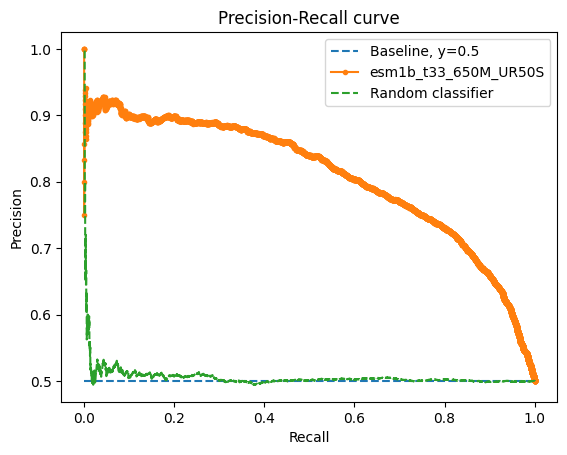

In [9]:
result_df = list_of_resut_df[0]
model_name = "esm1b_t33_650M_UR50S" # polyphen2_HVAR, esm1b_t33_650M_UR50S
model_pred_col = model_name + "_pred"

result_df["pred"]=(result_df[model_pred_col]-result_df[model_pred_col].min())/(result_df[model_pred_col].max()-result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]

non_nan_result_df = result_df[~pd.isna(result_df[model_pred_col])]  # taking df for only non-NAN values

if model_name in models_smaller_means_damaging:
    non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)

auc_roc_score, larger_means_positive_class = get_auc_roc_score(non_nan_result_df)
if not larger_means_positive_class:
    non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)

auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
print(thresholds.shape)
f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th(precisions, recalls, thresholds)

# f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th_(non_nan_result_df)

# print(thresholds.shape)
# print(precisions)
# print(recalls)

import matplotlib.pyplot as plt
plt.plot([0,1], [.5, .5], linestyle='--', label='Baseline, y=0.5')# precisions_list.append(p)
plt.plot(recalls, precisions, marker='.', label=f'{model_name}')


import random
result_df["pred"] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
non_nan_result_df = result_df[~pd.isna(result_df[model_pred_col])]  # taking df for only non-NAN values
auc_pr_score, p, r, t = get_auc_pr_score(non_nan_result_df)
f1_max, th_max, p, r, t = get_f1max_and_th(p, r, t)
plt.plot(r, p, linestyle='--', label="Random classifier")


plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend()
plt.title("Precision-Recall curve")
plt.show()


# pathogenicity = result_df[result_df["class"]==task]
# neutral = result_df[result_df["class"]=="neutral"]

# bins = 100 # 20, 100, 500
# plt.hist(pathogenicity["pred"], bins=bins, density=False, log=False, alpha=.6, label=f"Pathogenicity-{model_name}")
# plt.hist(neutral["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"Neutral-{model_name}")

# plt.legend()
# plt.show()

In [10]:
performance_scores_sum_dict = {}

for analysis_no, result_df in enumerate(list_of_resut_df):
    output_file = home_dir+f"models/aa_common/performance_analysis/{task}_analysis/{analysis_no}.csv"

    out = open(output_file, 'w')
    out.write("Models\\Metrics")
    for metric in metrics:
        out.write(f"\t{metric}")
    out.write("\n")


    for i, (model_root, model_name) in enumerate(model_root_and_name_tuple_list):
        print(model_name)
        model_pred_col = model_name + "_pred"
        result_df["pred"]=(result_df[model_pred_col]-result_df[model_pred_col].min())/(result_df[model_pred_col].max()-result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]
        
        non_nan_result_df = result_df[~pd.isna(result_df[model_pred_col])]  # taking df for only non-NAN values
        
        if model_name in models_smaller_means_damaging: # this is we know from papers
            non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
        
        auc_roc_score, larger_means_positive_class = get_auc_roc_score(non_nan_result_df)
        if not larger_means_positive_class:
            non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)

        auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
        f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th(precisions, recalls, thresholds)
        precision = get_precision_score(non_nan_result_df, th_max)
        recall = get_recall_score(non_nan_result_df, th_max)
        accuracy = get_accuracy_score(non_nan_result_df, th_max)
        balanced_accuracy = get_balanced_accuracy_score(non_nan_result_df, th_max)
        mcc = get_matthews_corrcoef(non_nan_result_df, th_max)
        
        permformance_scores = [auc_roc_score, auc_pr_score, f1_max, th_max, precision, recall, accuracy, balanced_accuracy, mcc]
        
        out.write(f"{model_name}")
        for score in permformance_scores:
            out.write(f"\t{score:.3f}")
        out.write("\n")
            
        if model_name not in performance_scores_sum_dict:
            performance_scores_sum_dict[model_name] = np.array(permformance_scores)
        else: performance_scores_sum_dict[model_name] += np.array(permformance_scores)
        # if i==5: break

    out.close()

    
output_file = home_dir+f"models/aa_common/performance_analysis/{task}_analysis/avg.csv"
out = open(output_file, 'w')
out.write("Models\\Metrics")
for metric in metrics:
    out.write(f"\t{metric}")
out.write("\n")
    
for model_name, permformance_scores_sum in performance_scores_sum_dict.items():
    out.write(f"{model_name}")
    for score in permformance_scores_sum:
        out.write(f"\t{score/10:.3f}")
    out.write("\n")
out.close()

sift
	AUC-ROC: 0.798
	AUC-PR: 0.789
	Best F1-Score: 0.748 at threshold: -0.018
	Precision score: 0.685 at threshold: -0.018
	Recall score: 0.825 at threshold: -0.018
	Accuracy score: 0.732 at threshold: -0.018
	Balanced accuracy score: 0.735 at threshold: -0.018
	MCC score: 0.476 at threshold: -0.018
polyphen2_HVAR
	AUC-ROC: 0.803
	AUC-PR: 0.760
	Best F1-Score: 0.745 at threshold: 0.497
	Precision score: 0.647 at threshold: 0.497
	Recall score: 0.879 at threshold: 0.497
	Accuracy score: 0.720 at threshold: 0.497
	Balanced accuracy score: 0.731 at threshold: 0.497
	MCC score: 0.477 at threshold: 0.497
cadd
	AUC-ROC: 0.789
	AUC-PR: 0.727
	Best F1-Score: 0.763 at threshold: 0.491
	Precision score: 0.655 at threshold: 0.491
	Recall score: 0.914 at threshold: 0.491
	Accuracy score: 0.721 at threshold: 0.491
	Balanced accuracy score: 0.723 at threshold: 0.491
	MCC score: 0.482 at threshold: 0.491
mvp
	AUC-ROC: 0.789
	AUC-PR: 0.764
	Best F1-Score: 0.742 at threshold: 0.832
	Precision score: 0

/tmp/ipykernel_1980656/147721721.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)


	AUC-ROC: 0.490
	AUC-PR: 0.551
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000
sequnet
	AUC-ROC: 0.368
	AUC-PR: 0.628
	Best F1-Score: 0.669 at threshold: 0.002
	Precision score: 0.508 at threshold: 0.002
	Recall score: 0.979 at threshold: 0.002
	Accuracy score: 0.514 at threshold: 0.002
	Balanced accuracy score: 0.514 at threshold: 0.002
	MCC score: 0.077 at threshold: 0.002
esm1b_t33_650M_UR50S
	AUC-ROC: 0.177
	AUC-PR: 0.808
	Best F1-Score: 0.769 at threshold: -0.508
	Precision score: 0.714 at threshold: -0.508
	Recall score: 0.832 at threshold: -0.508
	Accuracy score: 0.750 at threshold: -0.508
	Balanced accuracy score: 0.750 at threshold: -0.508
	MCC score: 0.506 at threshold: -0.508
esm1v_t33_650M_UR90S
	AUC-ROC: 0.187
	AUC-PR: 0.804
	Best F1-Score: 0.764 at threshold

/tmp/ipykernel_1980656/147721721.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_1980656/147721721.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)


	AUC-ROC: 0.222
	AUC-PR: 0.779
	Best F1-Score: 0.737 at threshold: -0.560
	Precision score: 0.701 at threshold: -0.560
	Recall score: 0.778 at threshold: -0.560
	Accuracy score: 0.723 at threshold: -0.560
	Balanced accuracy score: 0.723 at threshold: -0.560
	MCC score: 0.449 at threshold: -0.560
prottrans_albert_bfd
	AUC-ROC: 0.212
	AUC-PR: 0.768
	Best F1-Score: 0.747 at threshold: -0.527
	Precision score: 0.666 at threshold: -0.527
	Recall score: 0.851 at threshold: -0.527
	Accuracy score: 0.712 at threshold: -0.527
	Balanced accuracy score: 0.712 at threshold: -0.527
	MCC score: 0.442 at threshold: -0.527
prottrans_xlnet_uniref100
	AUC-ROC: 0.415
	AUC-PR: 0.634
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000
prottrans_t5_bfd
	AUC-ROC: 0.531
	AUC-PR: 0.520
	Best F1-Score

/tmp/ipykernel_1980656/147721721.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)


	Recall score: 1.000 at threshold: -0.996
	Accuracy score: 0.500 at threshold: -0.996
	Balanced accuracy score: 0.500 at threshold: -0.996
	MCC score: 0.011 at threshold: -0.996
sequnet
	AUC-ROC: 0.370
	AUC-PR: 0.623
	Best F1-Score: 0.669 at threshold: 0.009
	Precision score: 0.517 at threshold: 0.009
	Recall score: 0.945 at threshold: 0.009
	Accuracy score: 0.531 at threshold: 0.009
	Balanced accuracy score: 0.531 at threshold: 0.009
	MCC score: 0.110 at threshold: 0.009
esm1b_t33_650M_UR50S
	AUC-ROC: 0.183
	AUC-PR: 0.801
	Best F1-Score: 0.768 at threshold: -0.589
	Precision score: 0.693 at threshold: -0.589
	Recall score: 0.860 at threshold: -0.589
	Accuracy score: 0.740 at threshold: -0.589
	Balanced accuracy score: 0.740 at threshold: -0.589
	MCC score: 0.494 at threshold: -0.589
esm1v_t33_650M_UR90S
	AUC-ROC: 0.195
	AUC-PR: 0.798
	Best F1-Score: 0.759 at threshold: -0.590
	Precision score: 0.692 at threshold: -0.590
	Recall score: 0.839 at threshold: -0.590
	Accuracy score: 0.733 

/tmp/ipykernel_1980656/147721721.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_1980656/147721721.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)


	Precision score: 0.707 at threshold: -0.529
	Recall score: 0.769 at threshold: -0.529
	Accuracy score: 0.725 at threshold: -0.529
	Balanced accuracy score: 0.725 at threshold: -0.529
	MCC score: 0.452 at threshold: -0.529
prottrans_albert_bfd
	AUC-ROC: 0.215
	AUC-PR: 0.765
	Best F1-Score: 0.746 at threshold: -0.520
	Precision score: 0.664 at threshold: -0.520
	Recall score: 0.852 at threshold: -0.520
	Accuracy score: 0.711 at threshold: -0.520
	Balanced accuracy score: 0.711 at threshold: -0.520
	MCC score: 0.439 at threshold: -0.520
prottrans_xlnet_uniref100
	AUC-ROC: 0.420
	AUC-PR: 0.631
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000
prottrans_t5_bfd
	AUC-ROC: 0.534
	AUC-PR: 0.524
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	R

/tmp/ipykernel_1980656/147721721.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)


	Recall score: 1.000 at threshold: -0.928
	Accuracy score: 0.500 at threshold: -0.928
	Balanced accuracy score: 0.500 at threshold: -0.928
	MCC score: 0.015 at threshold: -0.928
sequnet
	AUC-ROC: 0.369
	AUC-PR: 0.627
	Best F1-Score: 0.669 at threshold: 0.008
	Precision score: 0.516 at threshold: 0.008
	Recall score: 0.948 at threshold: 0.008
	Accuracy score: 0.530 at threshold: 0.008
	Balanced accuracy score: 0.530 at threshold: 0.008
	MCC score: 0.108 at threshold: 0.008
esm1b_t33_650M_UR50S
	AUC-ROC: 0.180
	AUC-PR: 0.806
	Best F1-Score: 0.765 at threshold: -0.557
	Precision score: 0.689 at threshold: -0.557
	Recall score: 0.861 at threshold: -0.557
	Accuracy score: 0.736 at threshold: -0.557
	Balanced accuracy score: 0.736 at threshold: -0.557
	MCC score: 0.488 at threshold: -0.557
esm1v_t33_650M_UR90S
	AUC-ROC: 0.188
	AUC-PR: 0.805
	Best F1-Score: 0.763 at threshold: -0.590
	Precision score: 0.699 at threshold: -0.590
	Recall score: 0.840 at threshold: -0.590
	Accuracy score: 0.739 

/tmp/ipykernel_1980656/147721721.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_1980656/147721721.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)


	Precision score: 0.704 at threshold: -0.523
	Recall score: 0.780 at threshold: -0.523
	Accuracy score: 0.726 at threshold: -0.523
	Balanced accuracy score: 0.726 at threshold: -0.523
	MCC score: 0.455 at threshold: -0.523
prottrans_albert_bfd
	AUC-ROC: 0.211
	AUC-PR: 0.773
	Best F1-Score: 0.749 at threshold: -0.528
	Precision score: 0.670 at threshold: -0.528
	Recall score: 0.851 at threshold: -0.528
	Accuracy score: 0.716 at threshold: -0.528
	Balanced accuracy score: 0.716 at threshold: -0.528
	MCC score: 0.448 at threshold: -0.528
prottrans_xlnet_uniref100
	AUC-ROC: 0.417
	AUC-PR: 0.636
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000
prottrans_t5_bfd
	AUC-ROC: 0.530
	AUC-PR: 0.520
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	R

/tmp/ipykernel_1980656/147721721.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)


	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000
sequnet
	AUC-ROC: 0.370
	AUC-PR: 0.623
	Best F1-Score: 0.668 at threshold: 0.002
	Precision score: 0.508 at threshold: 0.002
	Recall score: 0.978 at threshold: 0.002
	Accuracy score: 0.515 at threshold: 0.002
	Balanced accuracy score: 0.514 at threshold: 0.002
	MCC score: 0.077 at threshold: 0.002
esm1b_t33_650M_UR50S
	AUC-ROC: 0.179
	AUC-PR: 0.805
	Best F1-Score: 0.766 at threshold: -0.517
	Precision score: 0.701 at threshold: -0.517
	Recall score: 0.844 at threshold: -0.517
	Accuracy score: 0.742 at threshold: -0.517
	Balanced accuracy score: 0.742 at threshold: -0.517
	MCC score: 0.495 at threshold: -0.517
esm1v_t33_650M_UR90S
	AUC-ROC: 0.194
	AUC-PR: 0.796
	Best F1-Score: 0.759 at threshold: -0.540
	Precision score: 0.693 at threshold: -0.540
	Recall score: 0.839

/tmp/ipykernel_1980656/147721721.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_1980656/147721721.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)


	Precision score: 0.695 at threshold: -0.560
	Recall score: 0.778 at threshold: -0.560
	Accuracy score: 0.718 at threshold: -0.560
	Balanced accuracy score: 0.718 at threshold: -0.560
	MCC score: 0.440 at threshold: -0.560
prottrans_albert_bfd
	AUC-ROC: 0.213
	AUC-PR: 0.770
	Best F1-Score: 0.744 at threshold: -0.437
	Precision score: 0.661 at threshold: -0.437
	Recall score: 0.851 at threshold: -0.437
	Accuracy score: 0.707 at threshold: -0.437
	Balanced accuracy score: 0.707 at threshold: -0.437
	MCC score: 0.433 at threshold: -0.437
prottrans_xlnet_uniref100
	AUC-ROC: 0.423
	AUC-PR: 0.629
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000
prottrans_t5_bfd
	AUC-ROC: 0.532
	AUC-PR: 0.524
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	R

/tmp/ipykernel_1980656/147721721.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)


	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000
sequnet
	AUC-ROC: 0.372
	AUC-PR: 0.620
	Best F1-Score: 0.668 at threshold: 0.008
	Precision score: 0.516 at threshold: 0.008
	Recall score: 0.948 at threshold: 0.008
	Accuracy score: 0.529 at threshold: 0.008
	Balanced accuracy score: 0.529 at threshold: 0.008
	MCC score: 0.106 at threshold: 0.008
esm1b_t33_650M_UR50S
	AUC-ROC: 0.175
	AUC-PR: 0.809
	Best F1-Score: 0.771 at threshold: -0.523
	Precision score: 0.723 at threshold: -0.523
	Recall score: 0.824 at threshold: -0.523
	Accuracy score: 0.755 at threshold: -0.523
	Balanced accuracy score: 0.755 at threshold: -0.523
	MCC score: 0.514 at threshold: -0.523
esm1v_t33_650M_UR90S
	AUC-ROC: 0.187
	AUC-PR: 0.802
	Best F1-Score: 0.767 at threshold: -0.615
	Precision score: 0.706 at threshold: -0.615
	Recall score: 0.839 at threshold: -0.615
	Accuracy score: 0.745 

/tmp/ipykernel_1980656/147721721.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_1980656/147721721.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)


	Recall score: 0.769 at threshold: -0.552
	Accuracy score: 0.728 at threshold: -0.552
	Balanced accuracy score: 0.728 at threshold: -0.552
	MCC score: 0.458 at threshold: -0.552
prottrans_albert_bfd
	AUC-ROC: 0.213
	AUC-PR: 0.763
	Best F1-Score: 0.749 at threshold: -0.554
	Precision score: 0.669 at threshold: -0.554
	Recall score: 0.851 at threshold: -0.554
	Accuracy score: 0.715 at threshold: -0.554
	Balanced accuracy score: 0.715 at threshold: -0.554
	MCC score: 0.448 at threshold: -0.554
prottrans_xlnet_uniref100
	AUC-ROC: 0.414
	AUC-PR: 0.635
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000
prottrans_t5_bfd
	AUC-ROC: 0.528
	AUC-PR: 0.518
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accur

/tmp/ipykernel_1980656/147721721.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)


	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000
sequnet
	AUC-ROC: 0.369
	AUC-PR: 0.625
	Best F1-Score: 0.669 at threshold: 0.011
	Precision score: 0.520 at threshold: 0.011
	Recall score: 0.936 at threshold: 0.011
	Accuracy score: 0.537 at threshold: 0.011
	Balanced accuracy score: 0.537 at threshold: 0.011
	MCC score: 0.121 at threshold: 0.011
esm1b_t33_650M_UR50S
	AUC-ROC: 0.185
	AUC-PR: 0.799
	Best F1-Score: 0.763 at threshold: -0.517
	Precision score: 0.704 at threshold: -0.517
	Recall score: 0.833 at threshold: -0.517
	Accuracy score: 0.741 at threshold: -0.517
	Balanced accuracy score: 0.741 at threshold: -0.517
	MCC score: 0.491 at threshold: -0.517
esm1v_t33_650M_UR90S
	AUC-ROC: 0.193
	AUC-PR: 0.798
	Best F1-Score: 0.759 at threshold: -0.589
	Precision score: 0.692 at threshold: -0.589
	Recall score: 0.839 at threshold: -0.589
	Accuracy score: 0.733 

/tmp/ipykernel_1980656/147721721.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_1980656/147721721.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)


	Accuracy score: 0.720 at threshold: -0.567
	Balanced accuracy score: 0.720 at threshold: -0.567
	MCC score: 0.443 at threshold: -0.567
prottrans_albert_bfd
	AUC-ROC: 0.214
	AUC-PR: 0.768
	Best F1-Score: 0.745 at threshold: -0.478
	Precision score: 0.691 at threshold: -0.478
	Recall score: 0.808 at threshold: -0.478
	Accuracy score: 0.724 at threshold: -0.478
	Balanced accuracy score: 0.724 at threshold: -0.478
	MCC score: 0.454 at threshold: -0.478
prottrans_xlnet_uniref100
	AUC-ROC: 0.412
	AUC-PR: 0.644
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000
prottrans_t5_bfd
	AUC-ROC: 0.533
	AUC-PR: 0.524
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Bala

/tmp/ipykernel_1980656/147721721.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)


	Recall score: 1.000 at threshold: -0.958
	Accuracy score: 0.500 at threshold: -0.958
	Balanced accuracy score: 0.500 at threshold: -0.958
	MCC score: 0.011 at threshold: -0.958
sequnet
	AUC-ROC: 0.374
	AUC-PR: 0.621
	Best F1-Score: 0.668 at threshold: 0.002
	Precision score: 0.507 at threshold: 0.002
	Recall score: 0.978 at threshold: 0.002
	Accuracy score: 0.514 at threshold: 0.002
	Balanced accuracy score: 0.514 at threshold: 0.002
	MCC score: 0.074 at threshold: 0.002
esm1b_t33_650M_UR50S
	AUC-ROC: 0.186
	AUC-PR: 0.798
	Best F1-Score: 0.765 at threshold: -0.581
	Precision score: 0.688 at threshold: -0.581
	Recall score: 0.860 at threshold: -0.581
	Accuracy score: 0.735 at threshold: -0.581
	Balanced accuracy score: 0.735 at threshold: -0.581
	MCC score: 0.486 at threshold: -0.581
esm1v_t33_650M_UR90S
	AUC-ROC: 0.195
	AUC-PR: 0.795
	Best F1-Score: 0.761 at threshold: -0.546
	Precision score: 0.696 at threshold: -0.546
	Recall score: 0.839 at threshold: -0.546
	Accuracy score: 0.736 

/tmp/ipykernel_1980656/147721721.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_1980656/147721721.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)


	Precision score: 0.718 at threshold: -0.544
	Recall score: 0.753 at threshold: -0.544
	Accuracy score: 0.728 at threshold: -0.544
	Balanced accuracy score: 0.728 at threshold: -0.544
	MCC score: 0.457 at threshold: -0.544
prottrans_albert_bfd
	AUC-ROC: 0.219
	AUC-PR: 0.762
	Best F1-Score: 0.744 at threshold: -0.552
	Precision score: 0.666 at threshold: -0.552
	Recall score: 0.843 at threshold: -0.552
	Accuracy score: 0.710 at threshold: -0.552
	Balanced accuracy score: 0.710 at threshold: -0.552
	MCC score: 0.435 at threshold: -0.552
prottrans_xlnet_uniref100
	AUC-ROC: 0.421
	AUC-PR: 0.634
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000
prottrans_t5_bfd
	AUC-ROC: 0.531
	AUC-PR: 0.521
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	R

/tmp/ipykernel_1980656/147721721.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)


	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000
sequnet
	AUC-ROC: 0.374
	AUC-PR: 0.620
	Best F1-Score: 0.668 at threshold: 0.013
	Precision score: 0.521 at threshold: 0.013
	Recall score: 0.931 at threshold: 0.013
	Accuracy score: 0.537 at threshold: 0.013
	Balanced accuracy score: 0.537 at threshold: 0.013
	MCC score: 0.120 at threshold: 0.013
esm1b_t33_650M_UR50S
	AUC-ROC: 0.182
	AUC-PR: 0.802
	Best F1-Score: 0.766 at threshold: -0.525
	Precision score: 0.702 at threshold: -0.525
	Recall score: 0.845 at threshold: -0.525
	Accuracy score: 0.743 at threshold: -0.525
	Balanced accuracy score: 0.743 at threshold: -0.525
	MCC score: 0.496 at threshold: -0.525
esm1v_t33_650M_UR90S
	AUC-ROC: 0.195
	AUC-PR: 0.794
	Best F1-Score: 0.759 at threshold: -0.554
	Precision score: 0.684 at threshold: -0.554
	Recall score: 0.851

/tmp/ipykernel_1980656/147721721.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_1980656/147721721.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)


	Precision score: 0.692 at threshold: -0.522
	Recall score: 0.780 at threshold: -0.522
	Accuracy score: 0.716 at threshold: -0.522
	Balanced accuracy score: 0.716 at threshold: -0.522
	MCC score: 0.436 at threshold: -0.522
prottrans_albert_bfd
	AUC-ROC: 0.218
	AUC-PR: 0.762
	Best F1-Score: 0.744 at threshold: -0.514
	Precision score: 0.670 at threshold: -0.514
	Recall score: 0.837 at threshold: -0.514
	Accuracy score: 0.712 at threshold: -0.514
	Balanced accuracy score: 0.712 at threshold: -0.514
	MCC score: 0.439 at threshold: -0.514
prottrans_xlnet_uniref100
	AUC-ROC: 0.416
	AUC-PR: 0.638
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000
prottrans_t5_bfd
	AUC-ROC: 0.527
	AUC-PR: 0.519
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	R

/tmp/ipykernel_1980656/147721721.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)


	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000
sequnet
	AUC-ROC: 0.370
	AUC-PR: 0.626
	Best F1-Score: 0.669 at threshold: 0.010
	Precision score: 0.519 at threshold: 0.010
	Recall score: 0.940 at threshold: 0.010
	Accuracy score: 0.534 at threshold: 0.010
	Balanced accuracy score: 0.533 at threshold: 0.010
	MCC score: 0.115 at threshold: 0.010
esm1b_t33_650M_UR50S
	AUC-ROC: 0.180
	AUC-PR: 0.802
	Best F1-Score: 0.768 at threshold: -0.544
	Precision score: 0.703 at threshold: -0.544
	Recall score: 0.846 at threshold: -0.544
	Accuracy score: 0.744 at threshold: -0.544
	Balanced accuracy score: 0.744 at threshold: -0.544
	MCC score: 0.499 at threshold: -0.544
esm1v_t33_650M_UR90S
	AUC-ROC: 0.190
	AUC-PR: 0.798
	Best F1-Score: 0.761 at threshold: -0.546
	Precision score: 0.696 at threshold: -0.546
	Recall score: 0.839 at threshold: -0.546
	Accuracy score: 0.737 

/tmp/ipykernel_1980656/147721721.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_1980656/147721721.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)


	Accuracy score: 0.732 at threshold: -0.538
	Balanced accuracy score: 0.732 at threshold: -0.538
	MCC score: 0.464 at threshold: -0.538
prottrans_albert_bfd
	AUC-ROC: 0.216
	AUC-PR: 0.762
	Best F1-Score: 0.747 at threshold: -0.431
	Precision score: 0.671 at threshold: -0.431
	Recall score: 0.842 at threshold: -0.431
	Accuracy score: 0.715 at threshold: -0.431
	Balanced accuracy score: 0.715 at threshold: -0.431
	MCC score: 0.445 at threshold: -0.431
prottrans_xlnet_uniref100
	AUC-ROC: 0.418
	AUC-PR: 0.636
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000
prottrans_t5_bfd
	AUC-ROC: 0.538
	AUC-PR: 0.529
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Bala

/tmp/ipykernel_1980656/147721721.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)


	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000
sequnet
	AUC-ROC: 0.369
	AUC-PR: 0.627
	Best F1-Score: 0.670 at threshold: 0.008
	Precision score: 0.518 at threshold: 0.008
	Recall score: 0.948 at threshold: 0.008
	Accuracy score: 0.532 at threshold: 0.008
	Balanced accuracy score: 0.532 at threshold: 0.008
	MCC score: 0.115 at threshold: 0.008
esm1b_t33_650M_UR50S
	AUC-ROC: 0.177
	AUC-PR: 0.806
	Best F1-Score: 0.770 at threshold: -0.568
	Precision score: 0.718 at threshold: -0.568
	Recall score: 0.832 at threshold: -0.568
	Accuracy score: 0.752 at threshold: -0.568
	Balanced accuracy score: 0.752 at threshold: -0.568
	MCC score: 0.511 at threshold: -0.568
esm1v_t33_650M_UR90S
	AUC-ROC: 0.186
	AUC-PR: 0.807
	Best F1-Score: 0.765 at threshold: -0.590
	Precision score: 0.702 at threshold: -0.590
	Recall score: 0.839

/tmp/ipykernel_1980656/147721721.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_1980656/147721721.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)


	Precision score: 0.719 at threshold: -0.509
	Recall score: 0.763 at threshold: -0.509
	Accuracy score: 0.732 at threshold: -0.509
	Balanced accuracy score: 0.732 at threshold: -0.509
	MCC score: 0.465 at threshold: -0.509
prottrans_albert_bfd
	AUC-ROC: 0.212
	AUC-PR: 0.773
	Best F1-Score: 0.747 at threshold: -0.499
	Precision score: 0.665 at threshold: -0.499
	Recall score: 0.852 at threshold: -0.499
	Accuracy score: 0.712 at threshold: -0.499
	Balanced accuracy score: 0.712 at threshold: -0.499
	MCC score: 0.441 at threshold: -0.499
prottrans_xlnet_uniref100
	AUC-ROC: 0.415
	AUC-PR: 0.638
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000
prottrans_t5_bfd
	AUC-ROC: 0.529
	AUC-PR: 0.516
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	R

In [12]:
import random

model_name = "random_classifier"
auc_roc_score_list, auc_pr_score_list, f1_max_list, th_max_list, precision_list, recall_list, accuracy_list, balanced_accuracy_list, mcc_list = [], [], [], [], [], [], [], [], []

for i in range(10):
    result_df["pred"] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
    non_nan_result_df = result_df
        
    auc_roc_score, larger_means_positive_class = get_auc_roc_score(non_nan_result_df)
    auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
    f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th(precisions, recalls, thresholds)
    precision = get_precision_score(non_nan_result_df, th_max)
    recall = get_recall_score(non_nan_result_df, th_max)
    accuracy = get_accuracy_score(non_nan_result_df, th_max)
    balanced_accuracy = get_balanced_accuracy_score(non_nan_result_df, th_max)
    mcc = get_matthews_corrcoef(non_nan_result_df, th_max)

    auc_roc_score_list.append(auc_roc_score)
    auc_pr_score_list.append(auc_pr_score)
    f1_max_list.append(f1_max)
    th_max_list.append(th_max)
    precision_list.append(precision)
    recall_list.append(recall)
    accuracy_list.append(accuracy)
    balanced_accuracy_list.append(balanced_accuracy)
    mcc_list.append(mcc)
    

permformance_scores = [np.mean(auc_roc_score_list), np.mean(auc_pr_score_list), np.mean(f1_max_list), 
                       np.mean(th_max_list), np.mean(precision_list), np.mean(recall_list), 
                       np.mean(accuracy_list), np.mean(balanced_accuracy_list), np.mean(mcc_list)]

output_file = home_dir+f"models/aa_common/performance_analysis/{task}_analysis/avg.csv"    
# output_file = home_dir+f"models/aa_common/performance_analysis/{task}.csv"
out = open(output_file, 'a')

out.write(f"{model_name}")
for score in permformance_scores:
    out.write(f"\t{score:.3f}")
out.write("\n")
out.close()

	AUC-ROC: 0.508
	AUC-PR: 0.506
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.011 at threshold: 0.000
	AUC-ROC: 0.497
	AUC-PR: 0.496
	Best F1-Score: 0.667 at threshold: 0.001
	Precision score: 0.500 at threshold: 0.001
	Recall score: 0.999 at threshold: 0.001
	Accuracy score: 0.501 at threshold: 0.001
	Balanced accuracy score: 0.501 at threshold: 0.001
	MCC score: 0.017 at threshold: 0.001
	AUC-ROC: 0.514
	AUC-PR: 0.513
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000
	AUC-ROC: 0.507
	AUC-PR: 0.505
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall sc